In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import boto3
import json

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1614090815143_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sm_client = boto3.client('secretsmanager',region_name='us-west-2')
secret_value = sm_client.get_secret_value(SecretId = 'emr_spark_qa')
username = json.loads(secret_value['SecretString'])['emr_spark_username']
password = json.loads(secret_value['SecretString'])['emr_spark_password']

#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user=username,
    password=password
    )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, r.review_rating, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT

query_testing = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.created_date > '2020-01-01' \
 "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                                    REVIEW_HEADLINE  ... NR  CS
0   325845322                        Sorry Lush, this was a miss  ...  1   0
1   325834628                                                123  ...  1   0
2   325798771                                                 At  ...  1   0
3   325679679                        JUVIA'S PLACE IS UNRELIABLE  ...  1   0
4   325850503                                                 NA  ...  1   0
..        ...                                                ...  ... ..  ..
95  267929609                           Gemini players can't cue  ...  1   0
96  308350541                         Really tastes like a smore  ...  1   0
97  308360371                              Hasn't been delivered  ...  1   1
98  308358511  Cheaper than Dirt? 199? Why does anyone patron...  ...  1   0
99  308346164                        Customer Service really bad  ...  1   0

[100 rows x 6 columns]

In [7]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409912 entries, 0 to 409911
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           409912 non-null  int64 
 1   REVIEW_HEADLINE  409912 non-null  object
 2   REVIEW_COMMENTS  409640 non-null  object
 3   REVIEW_RATING    409912 non-null  int64 
 4   NR               409912 non-null  int64 
 5   CS               409912 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.8+ MB

In [8]:
query_testing_2 = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.created_date > '2020-01-01' \
 "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265498 entries, 0 to 8265497
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   REVIEW_RATING    int64 
 4   NR               int64 
 5   CS               int64 
dtypes: int64(4), object(2)
memory usage: 378.4+ MB

In [10]:
#Using limit 500000 is not random, pull in all w/ no labels and then take random sample from there
from random import sample 
reviews_3 = reviews_2.sample(n=409912, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
reviews_3['NR'].sum(axis=0)
#reviews_2[reviews_2['NR']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [12]:
reviews = pd.concat([reviews, reviews_3], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                    REVIEW_HEADLINE  ... NR  CS
0        325845322        Sorry Lush, this was a miss  ...  1   0
1        325834628                                123  ...  1   0
2        325798771                                 At  ...  1   0
3        325679679        JUVIA'S PLACE IS UNRELIABLE  ...  1   0
4        325850503                                 NA  ...  1   0
...            ...                                ...  ... ..  ..
8119672  320509267                   Soft and Snuggly  ...  0   0
7079250  330443188                    Beautiful jeans  ...  0   0
4654549  283718278                 Excellent growbags  ...  0   0
4998494  280960452                        Undisclosed  ...  0   0
3714463  285128863  Like finding water in the desert.  ...  0   0

[819824 rows x 6 columns]

In [13]:
reviews['NR'].sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

409912

In [14]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819824 entries, 0 to 3714463
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           819824 non-null  int64 
 1   REVIEW_HEADLINE  819824 non-null  object
 2   REVIEW_COMMENTS  819504 non-null  object
 3   REVIEW_RATING    819824 non-null  int64 
 4   NR               819824 non-null  int64 
 5   CS               819824 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 43.8+ MB

In [15]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] =  reviews['REVIEW_HEADLINE']  + ' ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
#reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<string>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.

In [16]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819824 entries, 0 to 3714463
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           819824 non-null  int64 
 1   REVIEW_HEADLINE  819824 non-null  object
 2   REVIEW_COMMENTS  819504 non-null  object
 3   REVIEW_RATING    819824 non-null  int64 
 4   NR               819824 non-null  int64 
 5   CS               819824 non-null  int64 
 6   ALL_TEXT         819504 non-null  object
dtypes: int64(4), object(3)
memory usage: 50.0+ MB

In [17]:
#X = reviews[['ALL_TEXT','REVIEW_RATING']]
#df.loc[:, df.columns != 'b']
X = reviews.loc[:, reviews.columns != 'NR']
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                    REVIEW_HEADLINE  \
0        325845322  Sorry Lush, this was a miss         
1        325834628  123                                 
2        325798771  At                                  
3        325679679  JUVIA'S PLACE IS UNRELIABLE         
4        325850503  NA                                  
...            ...  ..                                  
8119672  320509267  Soft and Snuggly                    
7079250  330443188  Beautiful jeans                     
4654549  283718278  Excellent growbags                  
4998494  280960452  Undisclosed                         
3714463  285128863  Like finding water in the desert.   

                                                                                                                                                                                                                                                                                                                           

In [18]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         NR
0        1 
1        1 
2        1 
3        1 
4        1 
...     .. 
8119672  0 
7079250  0 
4654549  0 
4998494  0 
3714463  0 

[819824 rows x 1 columns]

In [19]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    409912
dtype: int64

In [20]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
#print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))
#25 mins for 65 mil rows
#16 mins for 30 mil rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
#print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
#ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(808202,1)
#print(ratings_vector_xtrain)
#ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(202051,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
#Combine TF-IDF and ratings vectors
#xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
#xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
xtrain_final = tfidf_vectors_xtrain
xtest_final = tfidf_vectors_xtest

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = lr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
#Support Vector Machine model
#clf = svm.SVC(probability=True)

#Need to change input type of y for training model
#ytrain = ytrain['NR'].ravel()
#ytrain.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
#Train model
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

In [31]:
#ytrain.dtypes
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    327930
dtype: int64

In [32]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
%matplotlib inline

In [35]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest, values_format = '.5g')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

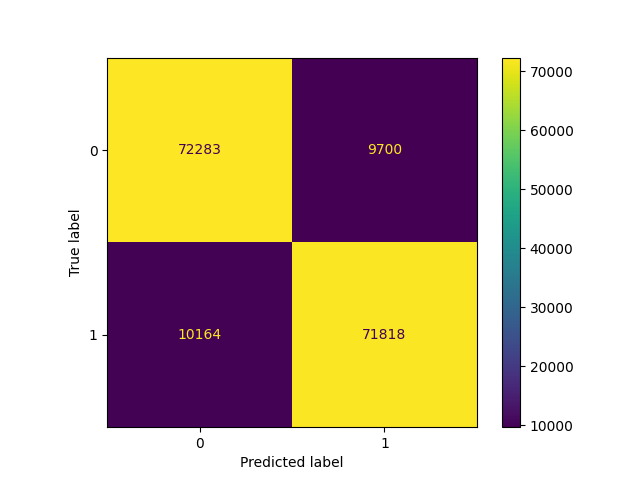

In [36]:
%matplot plt

In [37]:
#reviews_xtest =xtest
#reviews_xtest['model_NR'] = y_pred
#reviews_xtest['NR'] = ytest

#ytrain_pred = clf.predict(xtrain_final)
#reviews_xtrain =xtrain
#reviews_xtrain['model_NR'] = ytrain_pred
#reviews_xtrain['NR'] = ytrain


#reviews= pd.concat([reviews_xtest, reviews_xtrain], axis=0)
#reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
#reviews=xtest

#Need to join y_pred back to initial set to see if CS label or not
#Join actual ys back in as well so that we can compare predicted vs actual along w/ if CS or not
#reviews['model_NR'] = y_pred
#reviews['NR'] = ytest
#reviews.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
#Apply tfidf to all reviews, run through all reviews to get if NR or not, then CS
reviews_2['ALL_TEXT'] =  reviews_2['REVIEW_HEADLINE']  + ' ' + reviews_2['REVIEW_COMMENTS']

tfidf_vectors = vectorizer.transform(reviews_2['ALL_TEXT'].apply(lambda x: np.str_(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:

y_pred_all = clf.predict(tfidf_vectors)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
reviews_2['model_NR']=y_pred_all

reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265498 entries, 0 to 8265497
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   REVIEW_RATING    int64 
 4   NR               int64 
 5   CS               int64 
 6   ALL_TEXT         object
 7   model_NR         int64 
dtypes: int64(5), object(3)
memory usage: 504.5+ MB

In [42]:
reviews = reviews_2
reviews.head()
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265498 entries, 0 to 8265497
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   REVIEW_RATING    int64 
 4   NR               int64 
 5   CS               int64 
 6   ALL_TEXT         object
 7   model_NR         int64 
dtypes: int64(5), object(3)
memory usage: 504.5+ MB

In [43]:
#reviews['regex_CS'] = reviews['ALL_TEXT'].str.contains(r'(CUSTOMER SERVICE|SHIP|STATUS|ORDER|DELIVER|RECEIVE|RECIEVE|REFUND|RETURN)', case=False)==True
#reviews['regex_CS'] = reviews['ALL_TEXT'].str.contains(r'(CUSTOMER SERVICE|SHIP|STATUS|(DIDN\'?T|NEVER|NOT) (RECEIVE|RECIEVE)|ORDER|DELIVER|REFUND|RETURN)', case=False)==True
reviews['ALL_TEXT_2'] = reviews['ALL_TEXT'].str.replace(r'(AMAZING|AWESOME|FANTASTIC|EXCELLENT|GREAT|GOOD|OUTSTANDING|SUPERB) CUSTOMER SERVICE|CUSTOMER SERVICE (IS|WAS) (AMAZING|AWESOME|FANTASTIC|EXCELLENT|GREAT|GOOD|OUTSTANDING|SUPERB)', '', case=False)

reviews['regex_CS'] = reviews['ALL_TEXT_2'].str.contains(r'CUSTOMER SERVICE|SHIP|STATUS|(DIDN\'?T|NEVER|NOT) (RECEIVE|RECIEVE)|DELIVER|REFUND|RETURN', case=False)==True


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<string>:3: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib64/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)

In [44]:
reviews['model_CS'] = 0

reviews.loc[(reviews['model_NR'] == 1) & (reviews['regex_CS'] == True), 'model_CS' ] = 1


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
reviews.head()
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265498 entries, 0 to 8265497
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   REVIEW_RATING    int64 
 4   NR               int64 
 5   CS               int64 
 6   ALL_TEXT         object
 7   model_NR         int64 
 8   ALL_TEXT_2       object
 9   regex_CS         bool  
 10  model_CS         int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 638.5+ MB

In [46]:
FP = reviews[(reviews['CS'] == 0) & (reviews['model_CS'] == 1)]
FN = reviews[(reviews['CS'] == 1) & (reviews['model_CS'] == 0)]
TP = reviews[(reviews['CS'] == 1) & (reviews['model_CS'] == 1)]
TN = reviews[(reviews['CS'] == 0) & (reviews['model_CS'] == 0)]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
#183781
#178855
FP['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

177745

In [48]:
#15751
#15770
FN['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

15774

In [49]:
TP['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5043

In [50]:
TN['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8066936

In [58]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
FN.head(100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(UGC_ID='314600836', REVIEW_HEADLINE='Can you heat this iced coffee to switch it up?', REVIEW_COMMENTS='Is this iced coffee able to be heated?  I like it cold but wanted to try it hot as well.', REVIEW_RATING=5, NR=0, CS=1, ALL_TEXT='Can you heat this iced coffee to switch it up? Is this iced coffee able to be heated?  I like it cold but wanted to try it hot as well.', model_NR=0, ALL_TEXT_2='Can you heat this iced coffee to switch it up? Is this iced coffee able to be heated?  I like it cold but wanted to try it hot as well.', regex_CS='false', model_CS=0), Row(UGC_ID='314683972', REVIEW_HEADLINE="Why sell the product if you don't have the filter?", REVIEW_COMMENTS="I feel like this is a complete rip-off. I purchase your air purifier but I cannot find any replacement filters? When are you getting more in stock? If you're not getting the replacement filters back in stock you've lost all my business. To anyone looking to buy from them, I wouldn't do it, it's not worth it, they never

In [52]:
from pyspark.sql.types import *

mySchema = StructType([StructField("UGC_ID", StringType(), True)\
,StructField("REVIEW_HEADLINE", StringType(), True)\
,StructField("REVIEW_COMMENTS", StringType(), True)\
,StructField("REVIEW_RATING", IntegerType(), True)\
,StructField("NR", IntegerType(), True)\
,StructField("CS", IntegerType(), True)\
,StructField("ALL_TEXT", StringType(), True)\
,StructField("model_NR", IntegerType(), True)\
,StructField("ALL_TEXT_2", StringType(), True)\
,StructField("regex_CS", StringType(), True)\
,StructField("model_CS", IntegerType(), True)])   



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
#Turn into spark dataframe in order to write to Snowflake
#Couldn't get write_pandas() to work to write directly from pandas to Snowflake
FN = spark.createDataFrame(FN, schema=mySchema)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
FN.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions) \
    .option("dbtable","CS_FN_TEST4_FULL").mode("append").save()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FN_test2_qmarkonly")
conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FP_test2_qmarkonly")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FP_test2")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.TEST_NLP_SPARK6")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.TEST_NLP_SWAP_TOKENS")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.880048310413578
Precision is:  0.882510784716516
Recall is:  0.8772285820028842
F1 Score is:  0.8798617555761784

In [48]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     78131
           1       0.89      0.87      0.88     78131

    accuracy                           0.88    156262
   macro avg       0.88      0.88      0.88    156262
weighted avg       0.88      0.88      0.88    156262

In [49]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [333]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [334]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

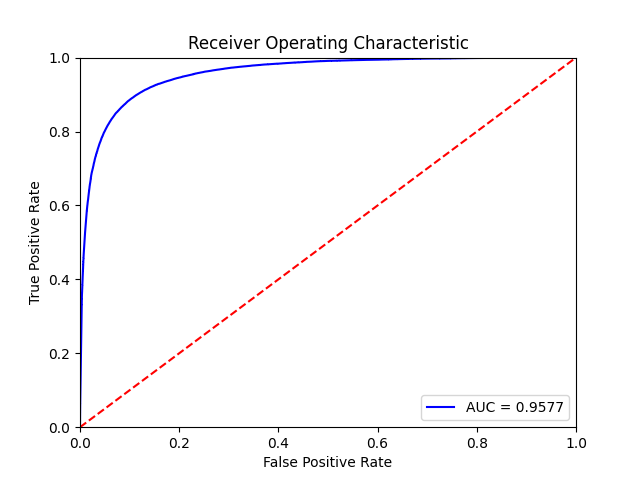

In [335]:
%matplot plt

In [336]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.5011553148098223
Optimal tpr value: 0.8880537279631401
Optimal fpr value: 0.10233007623751744

In [337]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [338]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.892861849330112
Precision is:  0.89667543885587
Recall is:  0.8880537279631401
F1 Score is:  0.8923437584294185

In [339]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

204885

In [341]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
pr_auc = metrics.auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [342]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [343]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

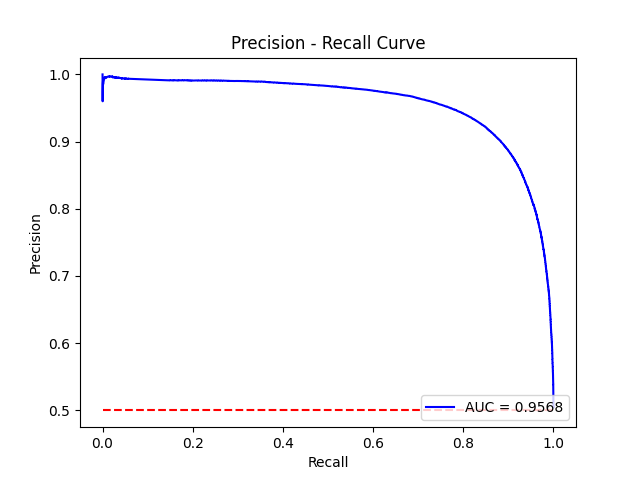

In [344]:
%matplot plt

In [345]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.445000, F-Score=0.893
Recall=0.904902
Precision=0.882101

In [346]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [347]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

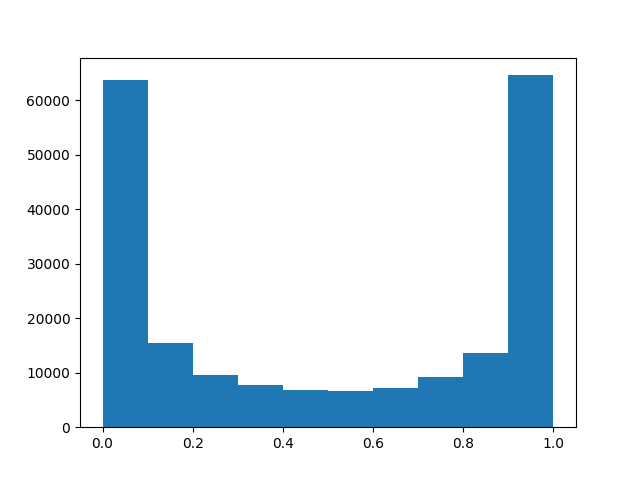

In [348]:
%matplot plt

In [349]:
preds_df = pd.DataFrame(data=preds, columns = ['pred_prob'])
#preds_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [350]:
ytest.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [351]:
hist_plot_data = pd.concat([ytest, preds_df], axis = 1)
#hist_plot_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [352]:
NR_0 = hist_plot_data.loc[hist_plot_data.NR == 0, 'pred_prob']
NR_1 = hist_plot_data.loc[hist_plot_data.NR == 1, 'pred_prob']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [356]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [357]:
kwargs = dict(alpha=0.5, bins=20)

plt.hist(NR_0, **kwargs, color='b', label='NR=0')
plt.hist(NR_1, **kwargs, color='g', label='NR=1')
plt.gca().set(title='Histogram of NR Label Probs', ylabel='Frequency', xlabel = 'Predicted Probability')
plt.legend();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

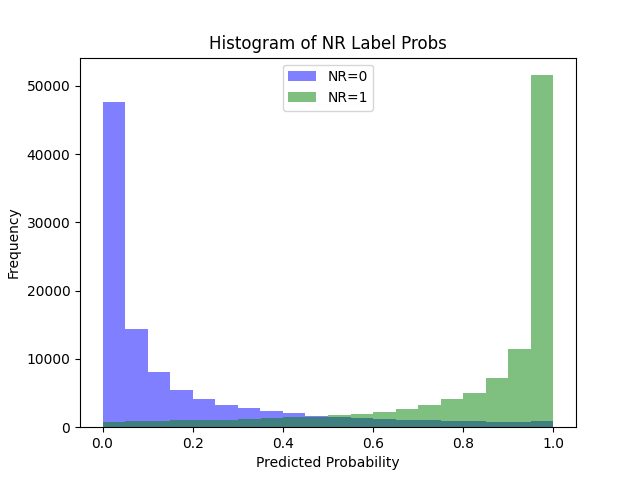

In [358]:
%matplot plt

In [316]:
#Amount of data that is actually 0 but predicted as 1 with probability > 80%
hist_plot_data.loc[(hist_plot_data.NR == 0) & (hist_plot_data.pred_prob > 0.8)].count()
#3233 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3233
pred_prob    3233
dtype: int64

In [317]:
#Amount of data that is actually 1 but predicted as 0 with probability < 20%
hist_plot_data.loc[(hist_plot_data.NR == 1) & (hist_plot_data.pred_prob < 0.2)].count()
#3683 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3683
pred_prob    3683
dtype: int64

In [318]:
#Amount of data (0 or 1) that is between probabilities 20% - 80%
hist_plot_data.loc[(hist_plot_data.pred_prob <0.8) & (hist_plot_data.pred_prob > 0.2)].count()
#47346 / 204885 = ~23%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           47346
pred_prob    47346
dtype: int64

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [287]:
xtest.reset_index(drop=True, inplace=True)
hist_plot_data.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
results = pd.concat([xtest, hist_plot_data], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [304]:
results['ALL_TEXT'] = results['ALL_TEXT'].astype(str)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [305]:
results_sparkdf = spark.createDataFrame(results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [306]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [307]:
 results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST_2").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…